In [25]:
# https://www.tensorflow.org/tutorials/images/classification?hl=ru
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print("TensorFlow version:", tf.__version__)
# подключение к Google Disk. В диалоге выбрать аккаунт и нажимать "Продолжить"
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!df -h


TensorFlow version: 2.17.0
Mounted at /content/gdrive
Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   33G   76G  30% /
tmpfs            64M     0   64M   0% /dev
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.2G  820M  59% /usr/sbin/docker-init
tmpfs           6.4G   21M  6.4G   1% /var/colab
/dev/sda1        77G   57G   20G  75% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G   74M   15G   1% /content/gdrive


После подключения Google-диска слева нажмите значок "Файлы" и найдите там папку DATA_img - скопируйте путь к ней и вставьте в путь в нижеследующей ячейке кода:

Found 150 files belonging to 3 classes.
Using 120 files for training.
['gorilla', 'men', 'women']
Found 150 files belonging to 3 classes.
Using 30 files for validation.


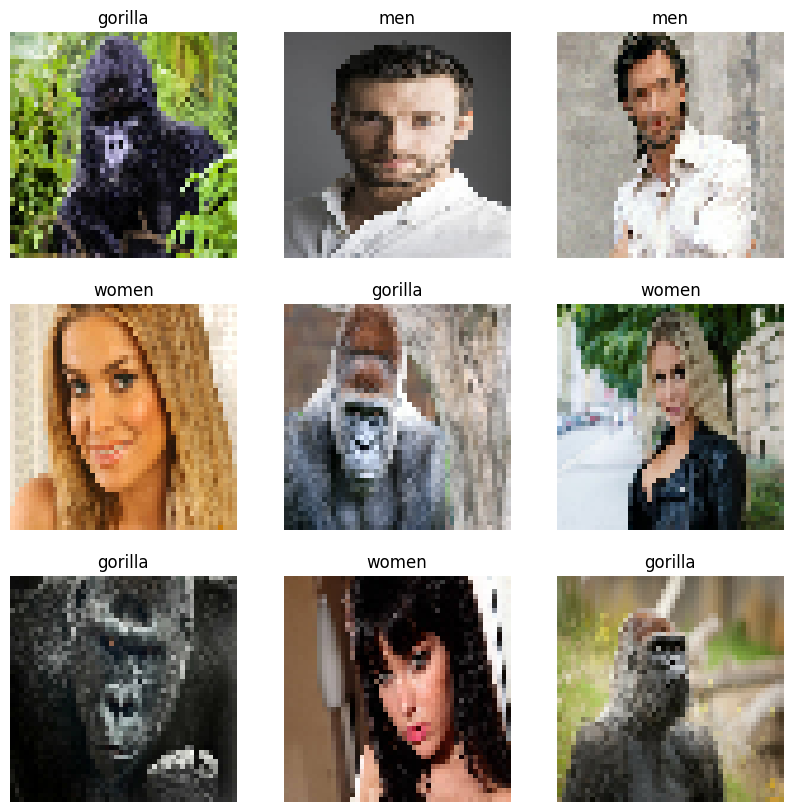

In [26]:
# Загрузка и предварительная обработка изображений
# https://www.tensorflow.org/tutorials/load_data/images?hl=ru
# аугментация поворот данных
# # https://www.tensorflow.org/tutorials/images/data_augmentation?hl=ru

data_dir='/content/gdrive/MyDrive/DATA_img/'  # ЗДЕСЬ ВСТАВИТЬ ПУТЬ К ПАПКЕ
img_height=48
img_width=48
batch_size=10
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


import matplotlib.pyplot as plt
# Визуализация части датасета
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Имена классов в атрибуте class_names этих наборов данных. Они соответствуют именам каталогов в алфавитном порядке

In [27]:
class_names = train_ds.class_names
print(class_names)

['gorilla', 'men', 'women']


Буферизованная предварительная выборка для повышения производительности модели, то есть, загружаем изоражения по частям. Dataset.cache сохраняет изображения в памяти после их загрузки с диска в течение первой эпохи. Это гарантирует, что набор данных не станет узким местом при обучении вашей модели, если ваш набор данных слишком велик

In [28]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [30]:
num_classes = len(class_names)
# Задание простой архитектуры сверточной нейронной сети (CNN), далее - модели
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
# Компиляция (настройка процесса обучения) модели
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()   # вывод информации об архитектуре модели
                  # None означает, что здесь может быть любое количество данных
# ОБУЧЕНИЕ модели
epochs=10     # количество эпох обучения
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 48, 48, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 24, 24, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 319,011 (1.22 MB)

 Trainable params: 319,011 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.2965 - loss: 1.1273 - val_accuracy: 0.6333 - val_loss: 1.0235
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5812 - loss: 0.9779 - val_accuracy: 0.6333 - val_loss: 0.7717
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6937 - loss: 0.7080 - val_accuracy: 0.6333 - val_loss: 0.7499
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6191 - loss: 0.6059 - val_accuracy: 0.5667 - val_loss: 0.6604
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8192 - loss: 0.4126 - val_accuracy: 0.6000 - val_loss: 0.6341
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8231 - loss: 0.4113 - val_accuracy: 0.7000 - val_loss: 0.7708
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7608 - loss: 0.4309 - val_accuracy: 0.8000 - val_loss: 0.6154
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8993 - loss: 0.3021 - val_accuracy: 0.7333 - v

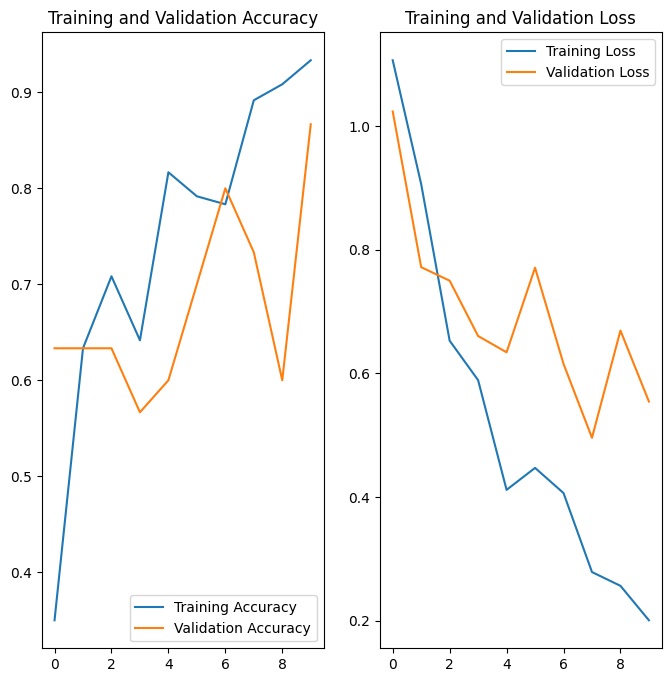

In [31]:
# графики потерь и точности на обучающих и проверочных наборах
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

На графиках выше точность обучения линейно увеличивается с течением времени, тогда как точность валидации останавливается на уровне около 80%. Разница в точности между точностью обучения и точностью валидации может свидетельствовать о переобучении модели - она плохо обобщает на новом наборе данных. Это может быть вызвано небольшим количеством данных (изображений) в обучающей выборке.
Используем аугментацию для получения новых изображений.
Аугментация - дополнение исходного набра данных с помощью случайных преобразований, которые дают правдоподобно выглядящие изображения. Ее можно включить в модель как слой, и запустить на графическом процессоре.

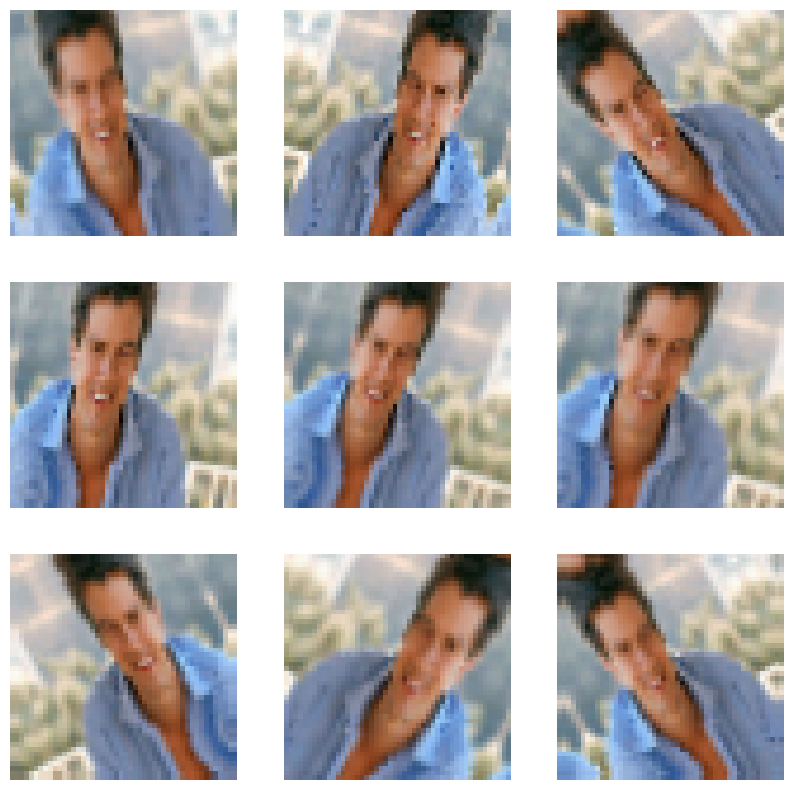

In [32]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
# Визуализация аугментации
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [33]:
# Другой метод снижения переобучения — введение слоя прореживания (dropout) в сеть:
# Dropout(0.2) - 20% разных нейронов постоянно выключаются при разных эпохах обучения
# Создаем новую CNN, содержащую слой  dropout и использующую аугментацию изображений

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)            │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_6 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.3713 - loss: 1.0965 - val_accuracy: 0.5333 - val_loss: 0.9759
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5220 - loss: 0.9470 - val_accuracy: 0.5667 - val_loss: 0.8206
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6853 - loss: 0.7034 - val_accuracy: 0.6333 - val_loss: 0.6808
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7040 - loss: 0.5968 - val_accuracy: 0.6333 - val_loss: 0.6398
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6302 - loss: 0.6747 - val_accuracy: 0.6667 - val_loss: 0.6500
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7656 - loss: 0.4984 - val_accuracy: 0.7333 - val_loss: 0.5641
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7715 - loss: 0.4674 - val_accuracy: 0.5667 - val_loss: 0.5915
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8195 - loss: 0.3901 - val_accuracy: 0.7667 - v

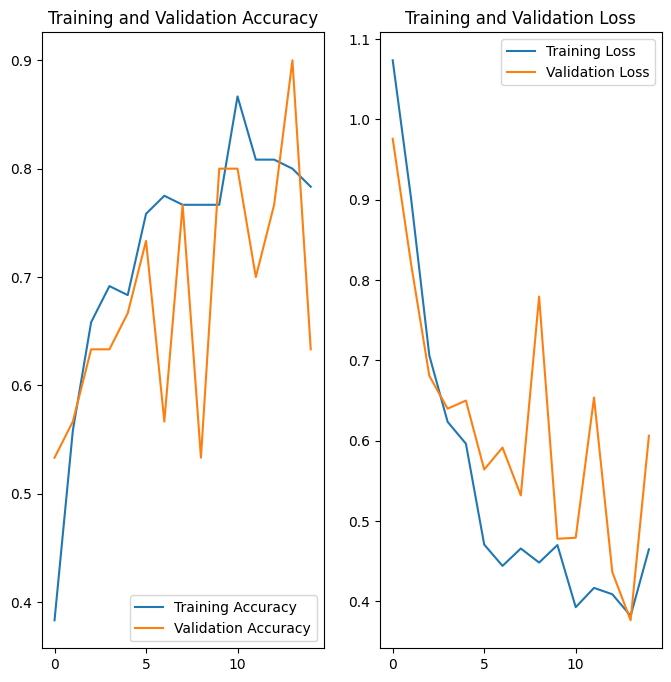

In [34]:
# Визуализация метрик обучения
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Братан, на изображении  men, AI уверен в этом на 85.74 %.


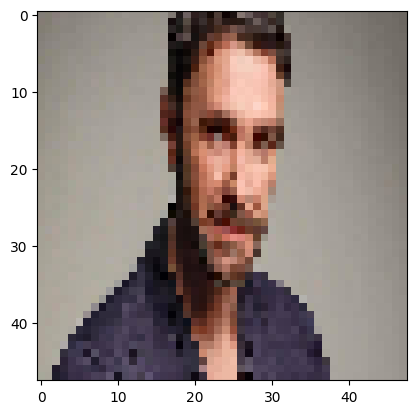

In [39]:
# Прогнозировать на основе новых данных (рабочий датасет)
# Примечание: слои augmentatio и Dropout данных неактивны во время вывода
# Для загрузки из Интернета:
#sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
#sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

# ___ Для классификации своего (рабочего) изображения или фото:
# - поместите классифиуируемое изображение в сессионный репозитарий Colab
# - скопируйте путь к файлу с изображением и вставьте его в нижеследующий код
img = tf.keras.utils.load_img(
    '/content/2.jpeg', target_size=(img_height, img_width) # загрузка изображения и приведение его к требуемому размеру
)
plt.imshow(img)
img_array = tf.keras.utils.img_to_array(img) # преобразование изображения в массив чисел
img_array = tf.expand_dims(img_array, 0) # создаем тензор -  добавляем внешнюю batch-ось, которая считает количество изображений
# Это нужно потому, что обучающие данные имели ajhve (none,n,m,3), то есть была еща ось none,
# а одно изображение имеет форму (n,m,3)

predictions = model.predict(img_array) # ПРИМЕНЕНИЕ модели к рабочему изображению
score = tf.nn.softmax(predictions[0])  # predictions - вектор и здесь выбираем максимум из него как результат классификации

print(
    "Братан, на изображении  {}, AI уверен в этом на {:.2f} %."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Использование TensorFlow Lite - набор инструментовдля проведения машинного обучения на мобильных, встроенных и периферийных устройствах.
Преобразуем обученную модель в меньший и более эффективный формат модели, называемый моделью TensorFlow Lite.


In [40]:
# Конвертирование модели в более "легкую" версию
# API конвертер моделей Keras автоматически использует сигнатуру по умолчанию
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Сохранение модели в файле
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmp1zv3q9n8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 48, 3), dtype=tf.float32, name='keras_tensor_69')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137949308200640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137949308197120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137949310564336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137949312846128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137949310565392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137949309460448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137949309456048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137949309465024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137949309458160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137949316135424: TensorSpec(shape=(), dtype=tf.resource, name=None)


Получить доступ к сохраненным сигнатурам модели TensorFlow Lite можно через класс tf.lite.Interpreter.

> Добавить блок с цитатой



In [64]:
TF_MODEL_FILE_PATH = 'model.tflite' # Путь по умолчанию к сохраненной модели TensorFlow Lite

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

# В этом примере есть одна подпись по умолчанию, которая называется serve_default
# Протестируем модель, выполнив вывод на примере изображения
# с помощью tf.lite.Interpreter.get_signature_runner, передав имя подписи следующим образом:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

# используем модель TensorFlow Lite для классификации изображения
# Прогноз, сгенерированный облегченной моделью, должен быть практически
# идентичен прогнозам, сгенерированным исходной моделью

# Распечатайте подписи из преобразованной модели, чтобы получить имена входов и выходов
# их названия надо сверить с названиями в строке сlassify_lite!!!
print('Сигнатуры: ',interpreter.get_signature_list())
predictions_lite = classify_lite(keras_tensor_69=img_array)['output_0'] # ПРИМЕНЕНИЕ модели

score = tf.nn.softmax(predictions_lite[0])
print(
    "\nБратан, на изображении  {}, легкая модель AI уверена в этом на {:.2f} %."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Сигнатуры:  {'serving_default': {'inputs': ['keras_tensor_69'], 'outputs': ['output_0']}}

Братан, на изображении  men, легкая модель AI уверена в этом на 85.74 %.
